# Machine Learning Framework for Coastal Oxygen Depletion Analysis

## Research Overview
This notebook implements a machine learning framework to investigate the impacts of stratification and eutrophication on interannual variability in coastal oxygen depletion, supporting the research work:  
**"Isolating the Impacts of Stratification and Eutrophication on Interannual Variability in Coastal Oxygen Depletion."**

## Methodology
The framework consists of three main components:

### 1. LightGBM Predictive Modeling
- Predicts bottom water Apparent Oxygen Utilization (AOU) using:
  - Stratification-related metrics
  - Annual classifiers

### 2. SHAP Value Interpretation
- Decomposes predictor variable contributions using Shapley Additive exPlanations
- Isolates stratification effects from other influencing factors
- Quantifies relative importance of drivers for interannual AOU variability

### 3. Eutrophication impacts on AOU variability
- Linear regression models applied to unexplained variance
- Identifies eutrophication-related factors influencing non-stratification-contributed AOU variability

## Spatial-Temporal Flexibility
The methodology can be applied to:
- User-defined subregions (plume vs. non-plume areas)
- Specific temporal windows (e.g., full period from 1995 to 2023; pre-2007 vs. post-2007 periods)


In [1]:
!pip install openpyxl
!pip install lightgbm
!pip install scikit-learn
!pip install hyperopt
!pip install shap
!pip install seaborn
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because norma

In [2]:

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib import gridspec
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
import shap
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import random
random.seed(20240326)
np.random.seed(20240326)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Determine the range of years we want to study
start_year = 1995
end_year = 2023

# Data file's location
Data_path = "WaterQuality_data_from_HKEPD.xlsx"

# Determine the subregion we want to study, including 'Plume' and 'NonPlume' regions

Subregion_selected = 'Plume'

## 1. Data preparation

In [4]:
# The list of station names included in Plume and NonPlume subregion.
Group_Plume = ['DM4', 'DM5', 'NM2', 'NM3', 'NM5', 'NM6', 'NM8', 'NM1', 'WM4', 'WM3', 
           'VM1', 'VM2', 'VM4', 'VM5', 'VM6', 'VM7', 'VM8', 'VM12', 'VM14', 'VM15',
            'JM3', 'JM4', 'EM1','SM1', 'SM2', 'SM3', 'SM4', 'SM5', 'SM6', 'SM7', 'SM9',  
            'SM17', 'SM18', 'SM10','SM11','SM12','SM13',
           'SM19', 'SM20', 'MM8', 'MM13',  'WM1', 'WM2', 'EM2', 'EM3'] 

Group_NonPlume =  ['TM6', 'TM7', 'TM8','MM1', 
            'MM2', 'MM3', 'MM4', 'MM5', 'MM6', 'MM7', 'MM14', 'MM15', 'MM16', 'MM17',
           'PM1', 'PM2', 'PM3', 'PM4', 'PM6', 'PM7', 'PM8', 'PM9', 'PM11','MM19']

if Subregion_selected == 'Plume':
    Group_study = Group_Plume
elif Subregion_selected == 'NonPlume':
    Group_study = Group_NonPlume
else: 
    raise ValueError("The name of the selected subregion is not valid.")

In [5]:
# Read the data and filter it based on the selected year and selected subregion we want to study. You can refill the path based on the file's location on your computer
Data_clean = pd.read_excel(Data_path, parse_dates=['Dates'])
Data_clean = Data_clean[Data_clean['Station'].isin(Group_study)]
Data_clean['Year'] = Data_clean['Dates'].dt.year 
Data_clean['Month'] = Data_clean['Dates'].dt.month
Data_clean = Data_clean.loc[Data_clean['Year'] >=start_year]
Data_clean = Data_clean.loc[Data_clean['Year'] <= end_year]

# Calculate the surface-bottom temperature and salinity difference 
Data_clean['T_difference'] = Data_clean['Temperature (°C)surface'] - Data_clean['Temperature (°C)bottom']
Data_clean['S_difference'] = Data_clean['Salinity (psu)bottom'] - Data_clean['Salinity (psu)surface']

# We consider the data from June, July, and August as our summertime data.
summer = Data_clean[Data_clean['Month'].isin([6,7,8])]

In [6]:
# Create a OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Perform one-hot encoding on the 'Year' column
one_hot_encoded = one_hot_encoder.fit_transform(summer[['Year']])


# Convert the one-hot encoded results into a DataFrame 
Year_index = one_hot_encoder.get_feature_names_out(['Year'])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=Year_index)
summer = summer.reset_index(drop=True)
one_hot_encoded_df = one_hot_encoded_df.reset_index(drop=True)

# Finally add it to the original DataFrame
summer = pd.concat([summer, one_hot_encoded_df], axis=1)

# Randomly select 15 rows
random_sample = summer.sample(n=10, random_state=1) 
random_sample

Unnamed: 0      Dates Station         Depth  \
3198       26441 2017-06-30     VM4  Bottom Water   
1227       10709 1998-06-30     NM8  Bottom Water   
891         9125 2002-06-30     NM2  Bottom Water   
1670       16447 2000-08-31    SM13  Bottom Water   
3459       27665 2017-06-30     VM7  Bottom Water   
1847       17275 2001-08-31    SM18  Bottom Water   
705         8261 1998-06-30     MM8  Bottom Water   
299         1435 2007-08-31     EM2  Bottom Water   
3215       26503 2022-08-31     VM4  Bottom Water   
2608       20802 2023-07-31     SM7  Bottom Water   

      Volatile Suspended Solids (mg/L)bottom  Unionised Ammonia (mg/L)bottom  \
3198                                   0.900                          0.0020   
1227                                   0.800                          0.0010   
891                                    1.000                          0.0050   
1670                                   0.600                          0.0020   
3459                                   1.400                          0.0150   
1847                                   1.600                          0.0020   
705                                    0.625                          0.0015   
299                                    3.800                          0.0010   
3215                                   2.000                          0.0020   
2608                                   1.800                          0.0005   

      Turbidity (NTU)bottom  Total Phosphorus (mg/L)bottom  \
3198                    1.7                          0.020   
1227                    6.2                          0.010   
891                    11.2                          0.010   
1670                   11.0                          0.030   
3459                    2.1                          0.060   
1847                   15.6                          0.030   
705                     6.7                          0.035   
299                    21.4                          0.040   
3215                    6.7                          0.060   
2608                    6.0                          0.040   

      Total Nitrogen (mg/L)bottom  Total Kjeldahl Nitrogen (mg/L)bottom  ...  \
3198                        0.280                                  0.17  ...   
1227                        0.300                                  0.29  ...   
891                         0.370                                  0.17  ...   
1670                        0.300                                  0.12  ...   
3459                        0.710                                  0.46  ...   
1847                        0.170                                  0.09  ...   
705                         0.885                                  0.85  ...   
299                         0.230                                  0.13  ...   
3215                        0.390                                  0.17  ...   
2608                        0.960                                  0.69  ...   

      Year_2014  Year_2015  Year_2016  Year_2017  Year_2018  Year_2019  \
3198        0.0        0.0        0.0        1.0        0.0        0.0   
1227        0.0        0.0        0.0        0.0        0.0        0.0   
891         0.0        0.0        0.0        0.0        0.0        0.0   
1670        0.0        0.0        0.0        0.0        0.0        0.0   
3459        0.0        0.0        0.0        1.0        0.0        0.0   
1847        0.0        0.0        0.0        0.0        0.0        0.0   
705         0.0        0.0        0.0        0.0        0.0        0.0   
299         0.0        0.0        0.0        0.0        0.0        0.0   
3215        0.0        0.0        0.0        0.0        0.0        0.0   
2608        0.0        0.0        0.0        0.0        0.0        0.0   

      Year_2020  Year_2021  Year_2022  Year_2023  
3198        0.0        0.0        0.0        0.0  
1227        0.0        0.0        0.0        0.0  
891      

## 2. Machine learning algorithm

### 2.1. LightGBM model for predicting bottom water AOU

In [7]:
# The selected stratification metrics in explaining spatial variablitiy of AOU
Stratification_metrics = ['Temperature (°C)surface', 'Salinity (psu)surface','Temperature (°C)bottom',
            'Salinity (psu)bottom','T_difference', 'S_difference', 'EPD water depth']

In [8]:
# Define cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=2024)

X = summer[Stratification_metrics + list(Year_index)]
y = summer['AOU']

global_mean = np.mean(summer['AOU'])

prediction_list = []
shap_values_list = []
X_combined_list = []
test_indices = []
test_list = []

for train_index, test_index in kf.split(X):
    # Record the test set indices
    test_indices.extend(test_index)
    
    # Split into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_test_original = X_test.copy(deep=True)

    # Standardization
    scaler = StandardScaler()
    X_train[Stratification_metrics] = scaler.fit_transform(X_train[Stratification_metrics])
    X_test[Stratification_metrics] = scaler.transform(X_test[Stratification_metrics])

    # Define parameter space
    param_space = {
        'num_leaves': hp.choice('num_leaves', range(20, 150)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'n_estimators': hp.choice('n_estimators', range(100, 1000)),
        'max_bin': hp.choice('max_bin', range(200, 500)),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0),
        'min_data_in_leaf': hp.choice('min_data_in_leaf', range(20, 100)),
        'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 0.2),
        'verbosity': -1
    }

    # Define objective function
    def objective(params):
        # Create LightGBM dataset object
        train_data = lgb.Dataset(X_train, label=y_train)
        # Cross-validation
        cv_results = lgb.cv(params, train_data, num_boost_round=1000, 
                            nfold=5, metrics='rmse', seed=42, stratified=False)
        # Get the best RMSE score
        best_rmse = min(cv_results['valid rmse-mean'])
        
        return {'loss': best_rmse, 'status': STATUS_OK}

    # Run hyperparameter optimization
    trials = Trials()
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, 
                       max_evals=20, trials=trials, rstate=np.random.default_rng(2024))
    
    # Map Hyperopt's parameter space to actual parameters used
    best_params_mapped = {
        'num_leaves': list(range(20, 150))[best_params['num_leaves']],
        'learning_rate': best_params['learning_rate'],
        'n_estimators': list(range(100, 1000))[best_params['n_estimators']],
        'max_bin': list(range(200, 500))[best_params['max_bin']],
        'bagging_fraction': best_params['bagging_fraction'],
        'feature_fraction': best_params['feature_fraction'],
        'min_data_in_leaf': list(range(20, 100))[best_params['min_data_in_leaf']],
        'min_gain_to_split': best_params['min_gain_to_split'],
        'verbosity': -1
    }
    
    # Retrain model using best parameters
    best_model = lgb.LGBMRegressor(**best_params_mapped)
    best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    y_pred = best_model.predict(X_test)
    R2 = metrics.r2_score(y_test, y_pred)
    
    # Create SHAP Explainer
    explainer = shap.TreeExplainer(best_model)

    # Calculate SHAP values on the test set
    shap_values = explainer.shap_values(X_test)
    
    # Get the baseline value for the current fold
    current_base_value = explainer.expected_value
    print(np.mean(y_pred))
    print(current_base_value)

    # Store SHAP values and test set
    shap_values_list.append(shap_values)
    X_combined_list.append(X_test_original)
    prediction_list.append(y_pred)
    test_list.append(y_test)

100%|██████████| 20/20 [02:47<00:00,  8.36s/trial, best loss: 0.9979639108609284]
2.2630661991523926
2.2647246287293465
100%|██████████| 20/20 [02:42<00:00,  8.14s/trial, best loss: 1.0104909079699698]
2.265057337987635
2.264144984510982
100%|██████████| 20/20 [02:45<00:00,  8.29s/trial, best loss: 1.0049677323081019]
2.2358828343940353
2.253430115945343
100%|██████████| 20/20 [03:39<00:00, 10.98s/trial, best loss: 1.0103171541251004]
2.244773963083084
2.2714955573185214
100%|██████████| 20/20 [03:25<00:00, 10.25s/trial, best loss: 0.9994915752176929]
2.28629898145862
2.2583538430761716


In [9]:
# Combine all folded SHAP values and datasets together
shap_values_combined = np.concatenate(shap_values_list, axis=0)
X_combined = pd.concat(X_combined_list)
prediction = np.concatenate(prediction_list, axis=0)

# Sort the data according to the test set index order
order = np.argsort(test_indices)
shap_values_combined = shap_values_combined[order, :]
X_combined = X_combined.iloc[order, :]
prediction = prediction[order]

# Save the model's predicted results and the unexplainable part into the original dataframe
summer['prediction'] = prediction
summer['res'] = summer['AOU'] - summer['prediction']

In [10]:
# Create SHAP value object
shap_values = shap.Explanation(values=shap_values_combined, base_values=0, data=X_combined.values, feature_names=X_combined.columns)
shap_values_Dataframe = pd.DataFrame(shap_values_combined, columns=Stratification_metrics + list(Year_index))
shap_values_Dataframe['Station'] = summer['Station']
shap_values_Dataframe['Year'] = summer['Year']

In [11]:
# Calculated the R2 values in each year
R2_year = []
for i in range(start_year, end_year + 1):
    er = summer.loc[summer['Year'] == i]
    R2 = metrics.r2_score(er['AOU'], er['prediction'])
    R2_year.append(R2)

# Create a DataFrame with years as index
years = range(start_year, end_year + 1) 
R2_df = pd.DataFrame(R2_year, index=years, columns=['R2'])

In [12]:
# Find the top 3 most important features
shap_importances = np.abs(shap_values.values).mean(axis=0)
top_indices = np.argsort(shap_importances)[-3:][::-1]

# Get the corresponding feature names
top_features = X_combined.columns[top_indices]

# Print the names of the top three features
print("Top 3 features with highest importance:")
for feature in top_features:
    print(feature)

Top 3 features with highest importance:
Temperature (°C)bottom
EPD water depth
S_difference


### 2.2 LightGBM model results interpretation and visualization

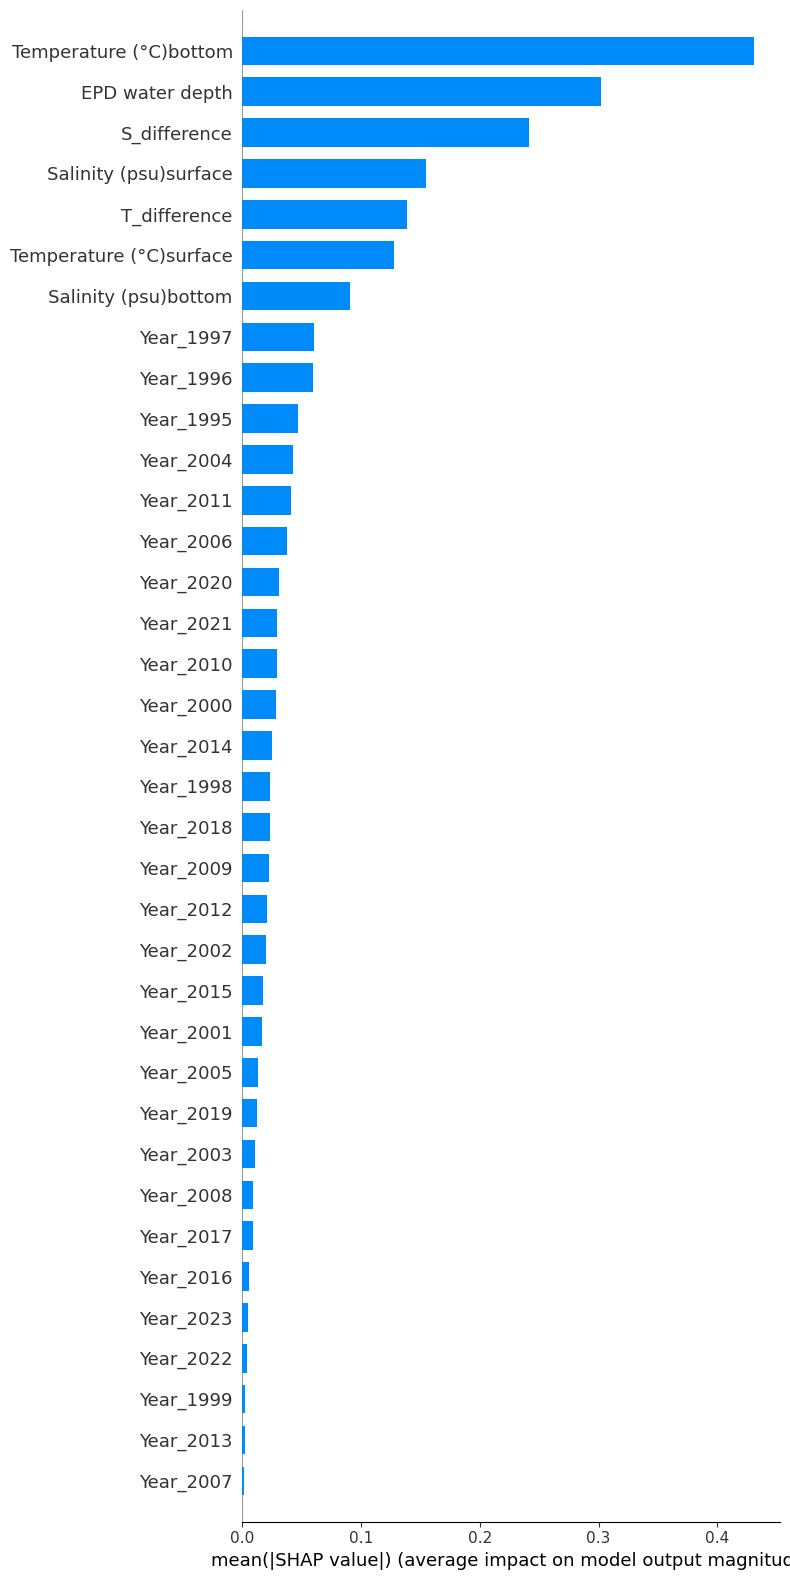

In [27]:
# SHAP interpretation to isolate contributions from stratification and non-stratification factors to AOU 
# SHAP summary plot
shap_array = shap_values.values
shap.summary_plot(shap_array, X_combined, max_display=100, plot_type='bar')

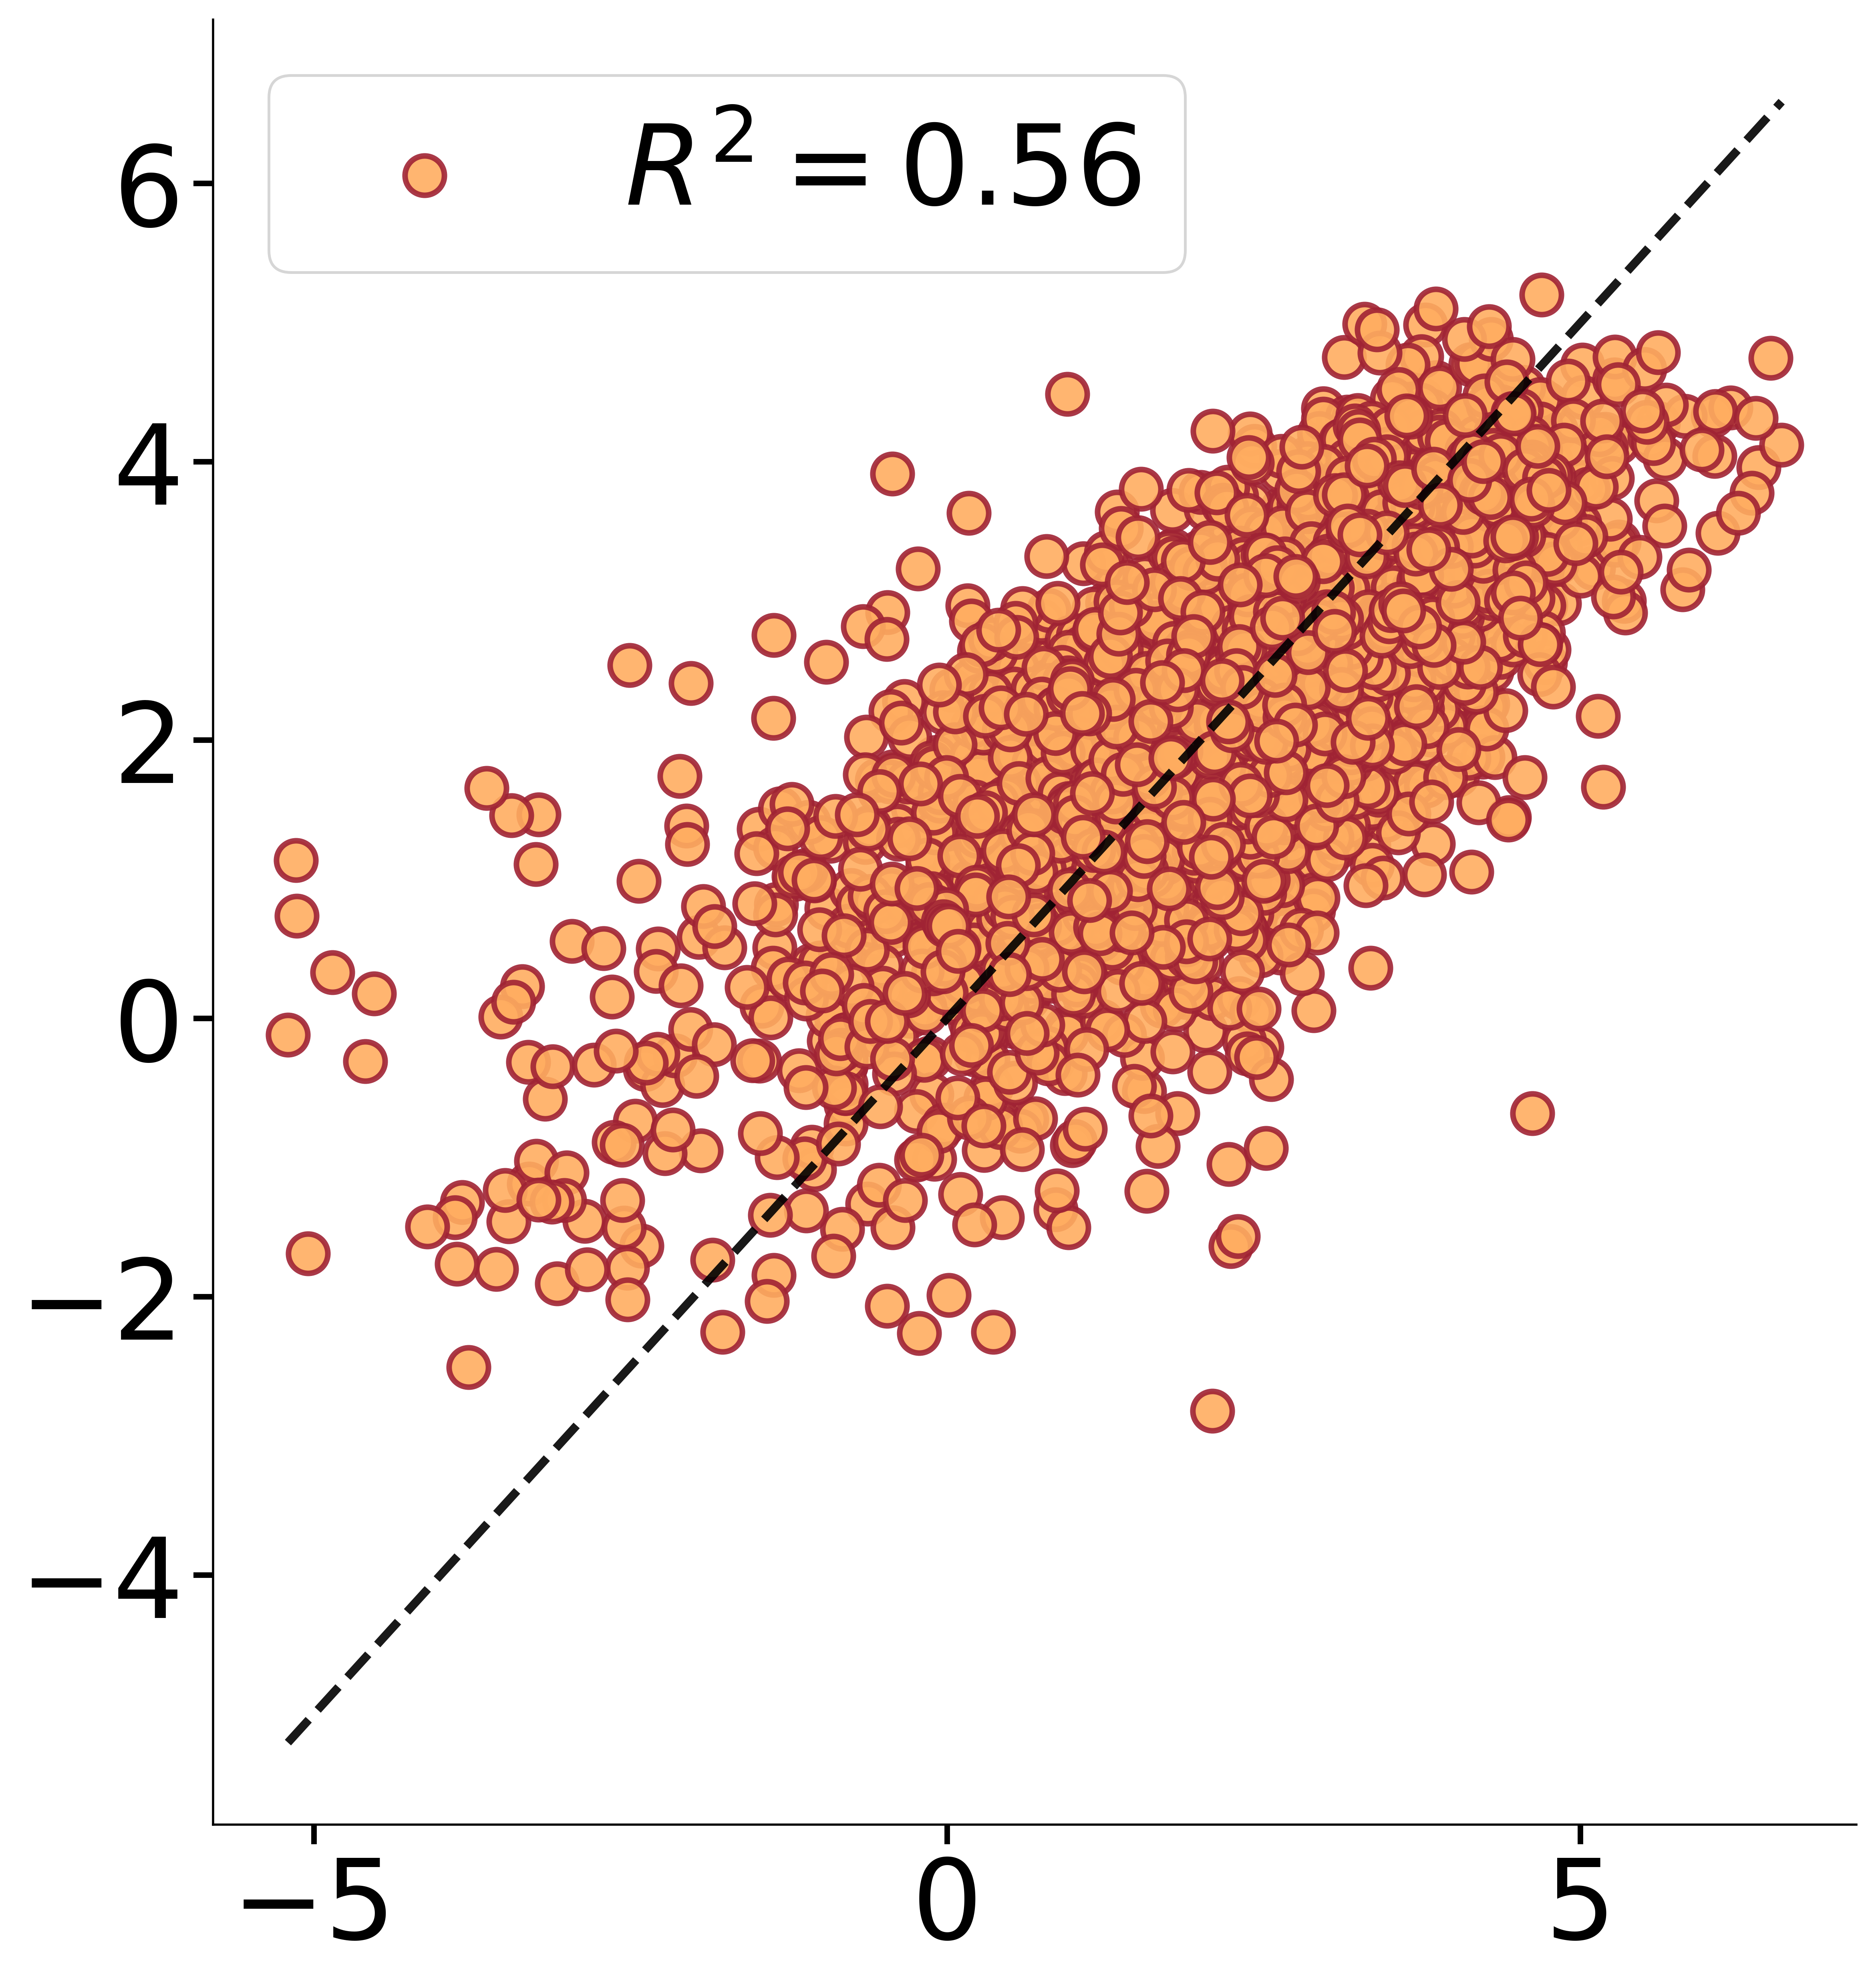

In [14]:
# Compare the observation and model predicted AOU

R2 = metrics.r2_score(summer['AOU'], summer['prediction'])
# Plot scatter plot and line plot on the main figure
fig, axs = plt.subplots(figsize=(10, 10), dpi=500)
sns.lineplot(x=summer['AOU'], y=summer['AOU'], color='black', linestyle='--', lw=3, ax=axs, zorder=1, alpha=0.9)
sns.scatterplot(x=summer['AOU'], y=summer['prediction'], s=200, color='#FFAD60', edgecolor='#A02334', linewidths=2,
                ax=axs, label=f'$R^2={R2:.2f}$', alpha=0.9, zorder=0)

axs.set_xlabel('')
axs.set_ylabel('')
axs.tick_params(axis='x', labelsize=40)
axs.tick_params(axis='y', labelsize=40)
axs.legend(loc='upper left', fontsize=40)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(axis='both', width=2, length=7)

plt.tight_layout()

In [15]:
# Calculate the annual stratification impact and yearly offsets
stratification_impact = shap_values_Dataframe.groupby('Year')[Stratification_metrics].mean()

yearly_offsets = []
for i in np.unique(summer['Year'].values):
    yearly_mean = shap_values_Dataframe.loc[shap_values_Dataframe['Year'] == i][f'Year_{i}'].mean()
    yearly_offsets.append(yearly_mean)
    

## 3. Regression models to identify eutrophication-related factors influencing non-stratification-contributed AOU variability

### 3.1 Data preparation

In [16]:
eutrophication_metrics = ['Orthophosphate Phosphorus (mmol/m3)surface', 'Nitrate Nitrogen (mmol/m3)surface', 'Chlorophyll-a (ug/L)surface',
                          'Turbidity (NTU)surface', 'discharge', 'WS']
other_metrics = ['density_difference','Dissolved Oxygen (mg/L)bottom', 'AOU', 'O2_sat','Turbidity (NTU)bottom','Suspended Solids (mg/L)bottom',
                 'SolarRadiation','Chlorophyll-a (ug/L)bottom']

In [17]:
# Calculate the spatial mean value of each variable in each year.
Mean_yearly = summer.groupby('Year')[Stratification_metrics+eutrophication_metrics+other_metrics+['prediction']].mean()
Mean_yearly['R2'] = R2_year

# The number of SW wind in summer should be calculated as the sum value.
pick_one_station = summer.loc[summer['Station'] == summer['Station'][0]]
SW_wind = pick_one_station.groupby('Year')['SW_wind'].sum()
Mean_yearly['SW_wind'] = SW_wind

# Calculate the spatial standard deviation value of each variable in each year.
Std_yearly = summer.groupby('Year')[Stratification_metrics+eutrophication_metrics+other_metrics+['prediction']].std()
Mean_yearly['AOU_Std'] = Std_yearly['AOU']

### 3.2 Stepwise linear regression method

In [18]:
X = Mean_yearly.reset_index()[eutrophication_metrics]
y = yearly_offsets

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [19]:
best_features = ['Orthophosphate Phosphorus (mmol/m3)surface', 'Nitrate Nitrogen (mmol/m3)surface', 'Chlorophyll-a (ug/L)surface',
                            'Turbidity (NTU)surface',]

In [20]:
X_selected = X_scaled[best_features]
y = yearly_offsets  

model = LinearRegression()
model.fit(X_selected, y)

yearly_offsets_prediction = model.predict(X_selected)

R2 = metrics.r2_score(y, yearly_offsets_prediction)

In [21]:
years = np.arange(start_year, end_year+1,1)
coef_df = pd.DataFrame(model.coef_, index=best_features,columns=['coefficient'])
total_abs_sum = coef_df['coefficient'].abs().sum()
coef_df['Proportion'] = coef_df['coefficient'].abs() / total_abs_sum 
coef_df['Proportion_sign'] = coef_df['Proportion'] * (coef_df['coefficient'].abs()/coef_df['coefficient'])
coef_df

coefficient  Proportion  \
Orthophosphate Phosphorus (mmol/m3)surface    -0.140125    0.318152   
Nitrate Nitrogen (mmol/m3)surface              0.089807    0.203904   
Chlorophyll-a (ug/L)surface                    0.116331    0.264127   
Turbidity (NTU)surface                        -0.094173    0.213818   

                                            Proportion_sign  
Orthophosphate Phosphorus (mmol/m3)surface        -0.318152  
Nitrate Nitrogen (mmol/m3)surface                  0.203904  
Chlorophyll-a (ug/L)surface                        0.264127  
Turbidity (NTU)surface                            -0.213818

### 3.3 Results visualization

In [22]:
R2 = metrics.r2_score(y, yearly_offsets_prediction)

fig = plt.figure(figsize=(35, 8), dpi=500)
gs = gridspec.GridSpec(1, 3)  

ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.barh(best_features, 
                coef_df['Proportion'], color='#fcc96e', height=0.5)

i=0
for bar in bars:
    width = coef_df['Proportion_sign'][i]
    ax1.text(abs(width)+0.015, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', ha='left',
             va='center',fontsize=40,c='#065279')
    i = i +1
ax1.grid(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.tick_params(axis='both', width=2, length=5) 
ax1.set_xlabel('Proportion', fontsize=35, labelpad=20)

#________________________________________________________________________________

ax2 = fig.add_subplot(gs[0, 1:3])

ax2.plot(np.unique(summer['Year'].values), y, '#3C3D37',lw=10,alpha=0.7, label='Yearly offsets')
ax2.plot(np.unique(summer['Year'].values), yearly_offsets_prediction,'o-', c= '#A02334', lw=8,markerfacecolor='#FFAD60', 
         markeredgecolor='#A02334', markeredgewidth=5, markersize=30, label=f'Prediction ($R^2={R2:.2f}$)')

ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylabel('Yearly offsets (mg/L)', fontsize=35, labelpad=15)
ax2.set_xlabel('Years', fontsize=35, labelpad=20)
ax2.tick_params(axis='both', width=3, length=5) 
major_ticks = years[::2]  
ax2.set_xticks(years)  
ax2.set_xticklabels([str(year) if year in major_ticks else "" for year in years], fontsize=25)  
ax2.set_ylim(-1,0.7)
ax2.legend(fontsize=30, loc='lower right')

for ax in [ax1, ax2]:
    # set spines width
    for spine in ax.spines.values():
        spine.set_linewidth(3) 
        
    ax.tick_params(axis='x', labelsize=30)  
    ax.tick_params(axis='y', labelsize=30) 
    ax.tick_params(axis='both', width=2, length=7)  
ax.grid(True)
plt.tight_layout()

## 4. Overall results visualization

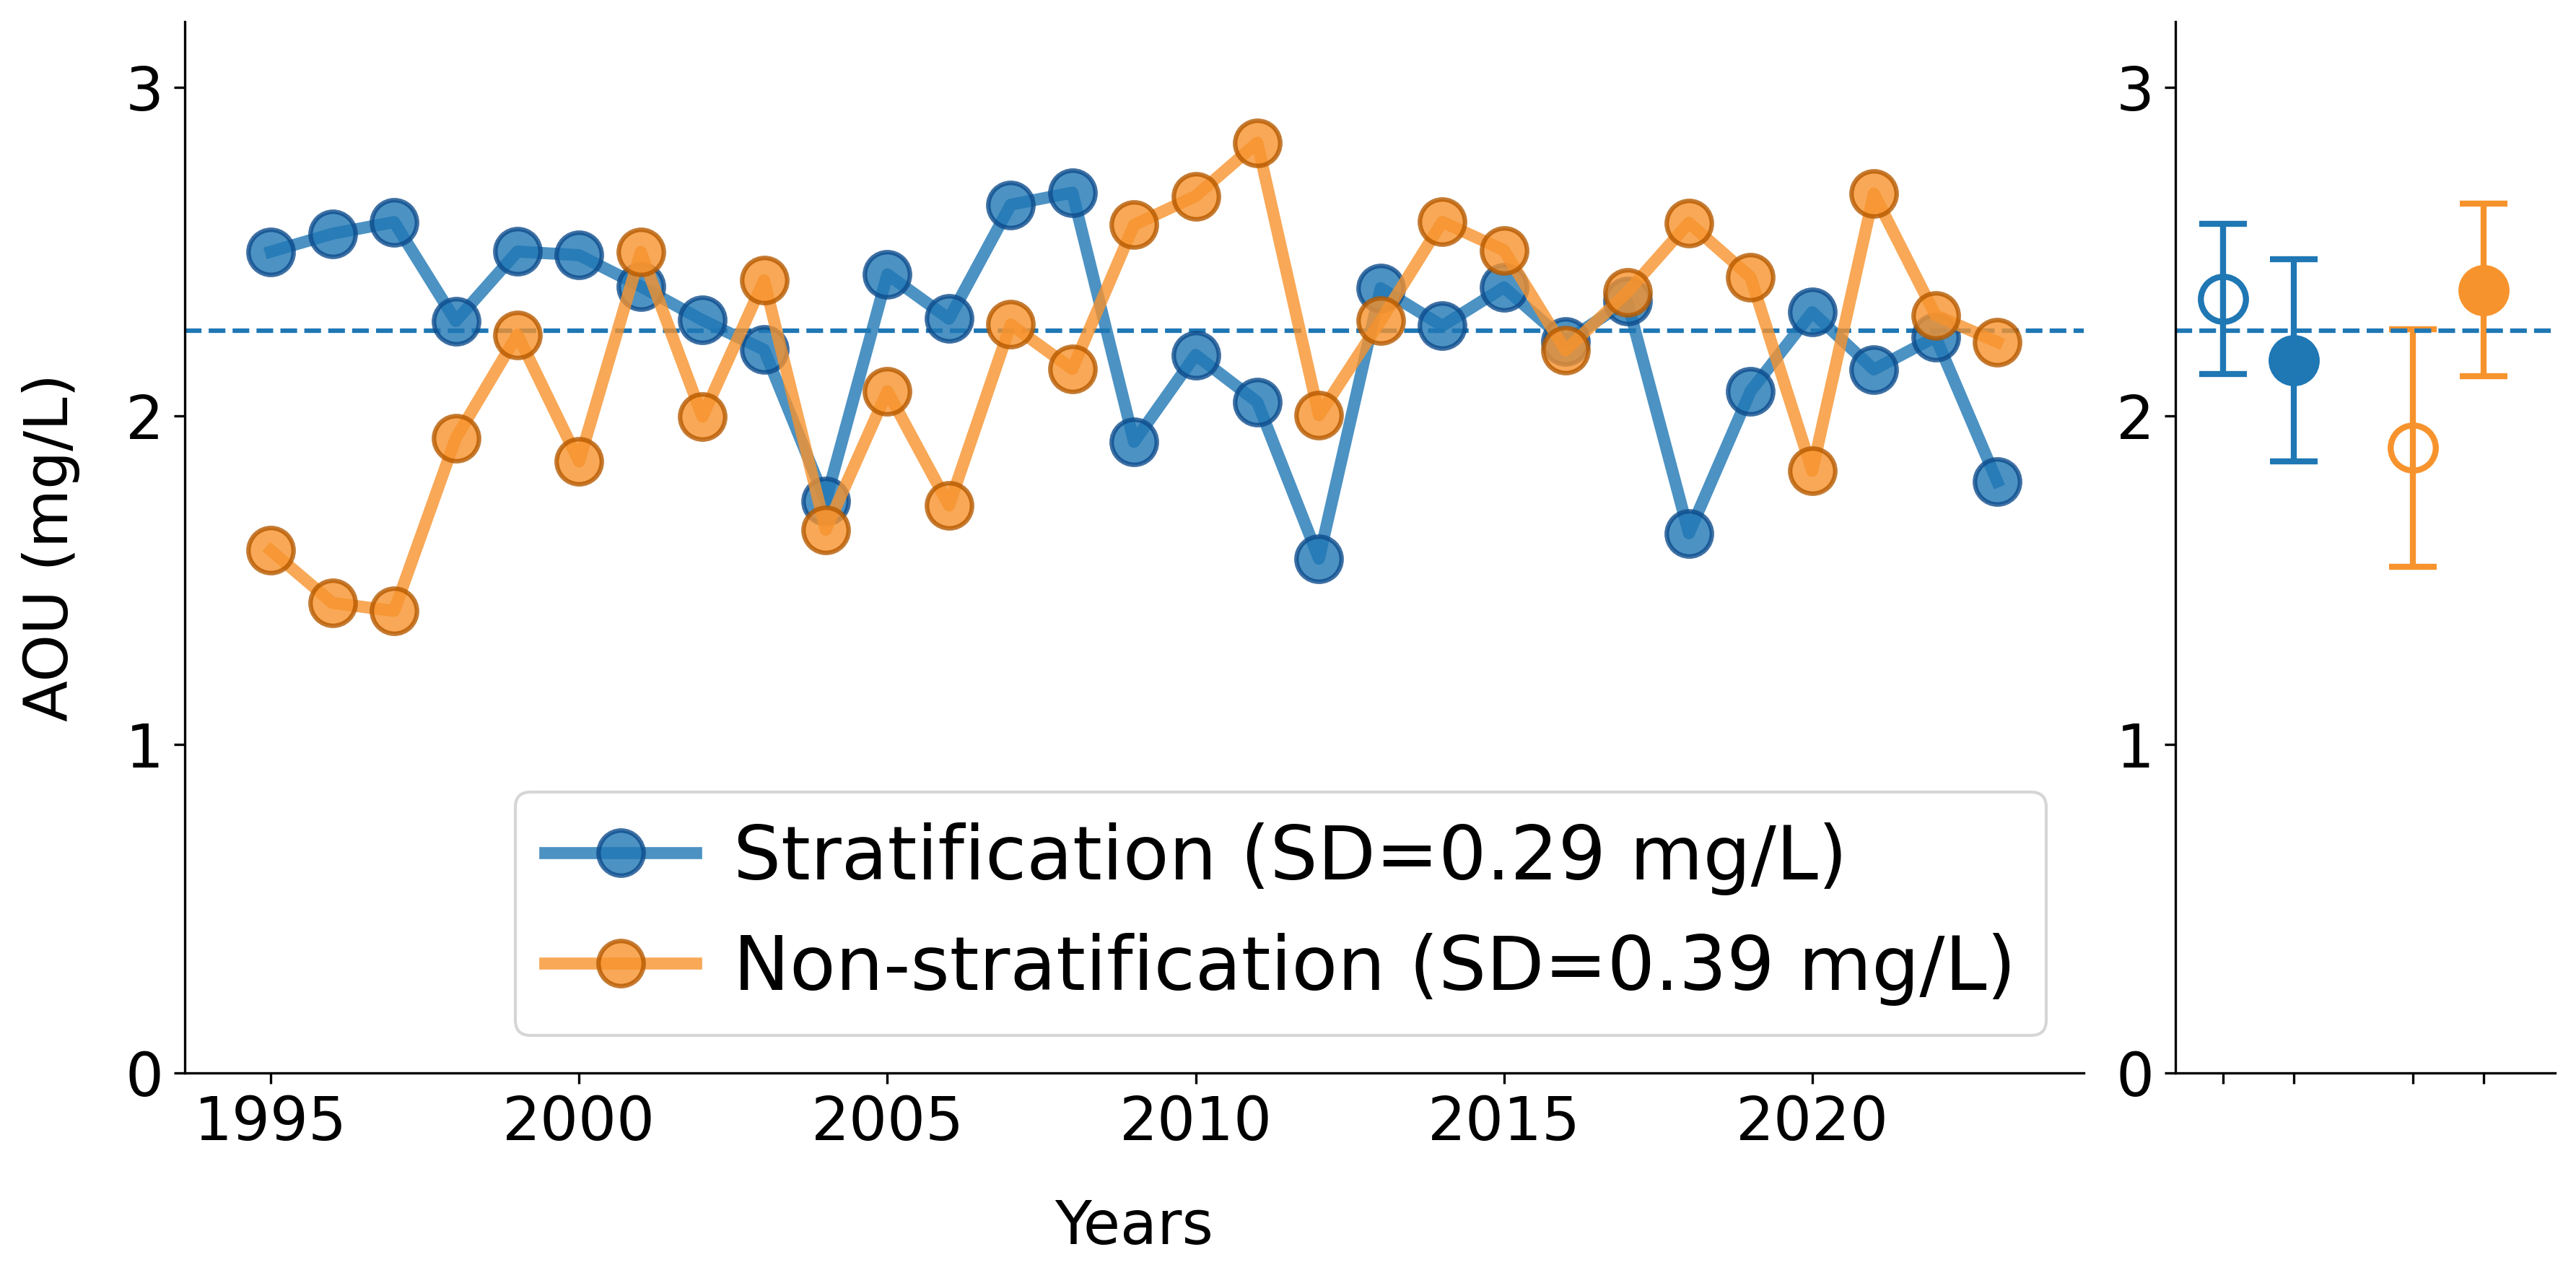

In [23]:
plot_var = 'prediction'
plt.figure(figsize=(12, 6), dpi=300)

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])

ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

plt.style.use('default')

stratification = stratification_impact.sum(axis=1).values
eutrophication = yearly_offsets_prediction
base_value = np.mean(summer.groupby('Year')['prediction'].mean())
ax1.axhline(base_value, ls='--')

years = np.unique(summer['Year'].values)
line1 = stratification + base_value
line2 = stratification + eutrophication + base_value
line3 = yearly_offsets + base_value

R2_eutrophication = metrics.r2_score(summer.groupby('Year')['AOU'].mean(), eutrophication + base_value)
R2_stratification = metrics.r2_score(summer.groupby('Year')['AOU'].mean(), line1)
R2_all = metrics.r2_score(summer.groupby('Year')['AOU'].mean(), line2)

ax1.plot(years, line1, 'o-', label=f'Stratification (SD={np.std(stratification_impact.sum(axis=1), ddof=1):.2f} mg/L)', c='tab:blue', lw=4,
         markeredgecolor='#0e4c8c', markeredgewidth=1.5, markersize=15,alpha=0.8)

ax1.plot(years, line3, 'o-', label=f'Non-stratification (SD={np.std(yearly_offsets, ddof=1):.2f} mg/L)',c='#f7932d', lw=4,
         markeredgecolor='#b65a00', markeredgewidth=1.5, markersize=15,alpha=0.8)

ax1.set_ylabel('AOU (mg/L)', fontsize=20, labelpad=15)
ax1.set_xlabel('Years', fontsize=20, labelpad=15)

ax1.set_yticks([0, 1, 2, 3])
ax1.legend(fontsize=25, loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0.5, 
           handletextpad=0.5, labelspacing=0.5)
ax1.set_ylim(0,3.2)
ax1.tick_params(axis='both', labelsize=20)

data_for_boxplot = pd.DataFrame({
    'Metric': np.concatenate([line1, line2, line3]),
    'Type': ['Stratification'] * len(line1) + ['Eutrophication'] * len(line2) + ['Yearly Offsets'] * len(line3),
    'Period': (
        ['1995-2006'] * len(line1[years < 2007]) + ['2007-2023'] * len(line1[years >= 2007]) +
        ['1995-2006'] * len(line2[years < 2007]) + ['2007-2023'] * len(line2[years >= 2007]) +
        ['1995-2006'] * len(line3[years < 2007]) + ['2007-2023'] * len(line3[years >= 2007])
    )
})

group_1 = data_for_boxplot.loc[(data_for_boxplot['Type'] == 'Stratification') & (data_for_boxplot['Period'] == '1995-2006')]
group_2 = data_for_boxplot.loc[(data_for_boxplot['Type'] == 'Stratification') & (data_for_boxplot['Period'] == '2007-2023')]

group_5 = data_for_boxplot.loc[(data_for_boxplot['Type'] == 'Yearly Offsets') & (data_for_boxplot['Period'] == '1995-2006')]
group_6 = data_for_boxplot.loc[(data_for_boxplot['Type'] == 'Yearly Offsets') & (data_for_boxplot['Period'] == '2007-2023')]


def get_mean_se(group):
    mean = group['Metric'].mean()
    se = group['Metric'].std() 
    return mean, se

means_se = {
    'Stratification_1995-2006': get_mean_se(group_1),
    'Stratification_2007-2023': get_mean_se(group_2),
    'Yearly Offsets_1995-2006': get_mean_se(group_5),
    'Yearly Offsets_2007-2023': get_mean_se(group_6),
}


positions = [0.6, 0.9, 1.4, 1.7]
colors = ['tab:blue', 'tab:blue', '#f7932d', '#f7932d']
labels = ['Strat 95-06', 'Strat 07-23', 'Offset 95-06', 'Offset 07-23']

for pos, (key, color) in zip(positions, zip(means_se.keys(), colors)):
    mean, se = means_se[key]
    if '1995-2006' in key:
        ax2.errorbar(pos, mean, yerr=se, fmt='o', color=color, capsize=8, markersize=15, elinewidth=2, markeredgewidth=2,capthick=2, markerfacecolor='none', markeredgecolor=color)
    else:
        ax2.errorbar(pos, mean, yerr=se, fmt='o', color=color, capsize=8, markersize=15, elinewidth=2, markeredgewidth=2,capthick=2, markerfacecolor=color, markeredgecolor=color)

ax2.axhline(base_value, ls='--')

ax2.set_xlabel('')
ax2.tick_params(axis='both', labelsize=20)
ax2.set_ylim(0, 3.2)
ax2.set_xlim(0.4, 2.0)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_xticks([0.6, 0.9, 1.4, 1.7])

ax2.set_xticklabels([]) 
for ax in [ax1, ax2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()


In [24]:
def calculate_trend_and_pvalue(years, values):
    slope, intercept, r_value, p_value, std_err = linregress(years, values)
    return slope, p_value  

trend_line1, p_value_line1 = calculate_trend_and_pvalue(years, line1)
trend_line2, p_value_line2 = calculate_trend_and_pvalue(years, line2)
trend_line3, p_value_line3 = calculate_trend_and_pvalue(years, line3)

print(f'Trend for Stratification (overall): {trend_line1:.4f} mg/L per year, p-value: {p_value_line1:.4f}')
print(f'Trend for Eutrophication (overall): {trend_line2:.4f} mg/L per year, p-value: {p_value_line2:.4f}')
print(f'Trend for Yearly Offsets (overall): {trend_line3:.4f} mg/L per year, p-value: {p_value_line3:.4f}')


periods = [(1995, 2006), (2007, 2023)]

for start, end in periods:
    mask = (years >= start) & (years <= end) 
    if np.any(mask): 
        trend_line1_period, p_value_line1_period = calculate_trend_and_pvalue(years[mask], line1[mask])
        trend_line2_period, p_value_line2_period = calculate_trend_and_pvalue(years[mask], line2[mask])
        trend_line3_period, p_value_line3_period = calculate_trend_and_pvalue(years[mask], line3[mask])

        print(f'Trend for Stratification ({start}-{end}): {trend_line1_period:.4f} mg/L per year, p-value: {p_value_line1_period:.4f}')
        print(f'Trend for Eutrophication ({start}-{end}): {trend_line2_period:.4f} mg/L per year, p-value: {p_value_line2_period:.4f}')
        print(f'Trend for Yearly Offsets ({start}-{end}): {trend_line3_period:.4f} mg/L per year, p-value: {p_value_line3_period:.4f}')

Trend for Stratification (overall): -0.0157 mg/L per year, p-value: 0.0115
Trend for Eutrophication (overall): 0.0070 mg/L per year, p-value: 0.3849
Trend for Yearly Offsets (overall): 0.0255 mg/L per year, p-value: 0.0015
Trend for Stratification (1995-2006): -0.0366 mg/L per year, p-value: 0.0496
Trend for Eutrophication (1995-2006): -0.0084 mg/L per year, p-value: 0.7067
Trend for Yearly Offsets (1995-2006): 0.0396 mg/L per year, p-value: 0.2035
Trend for Stratification (2007-2023): -0.0186 mg/L per year, p-value: 0.2337
Trend for Eutrophication (2007-2023): -0.0104 mg/L per year, p-value: 0.6225
Trend for Yearly Offsets (2007-2023): -0.0073 mg/L per year, p-value: 0.5895


0.9211361304268053


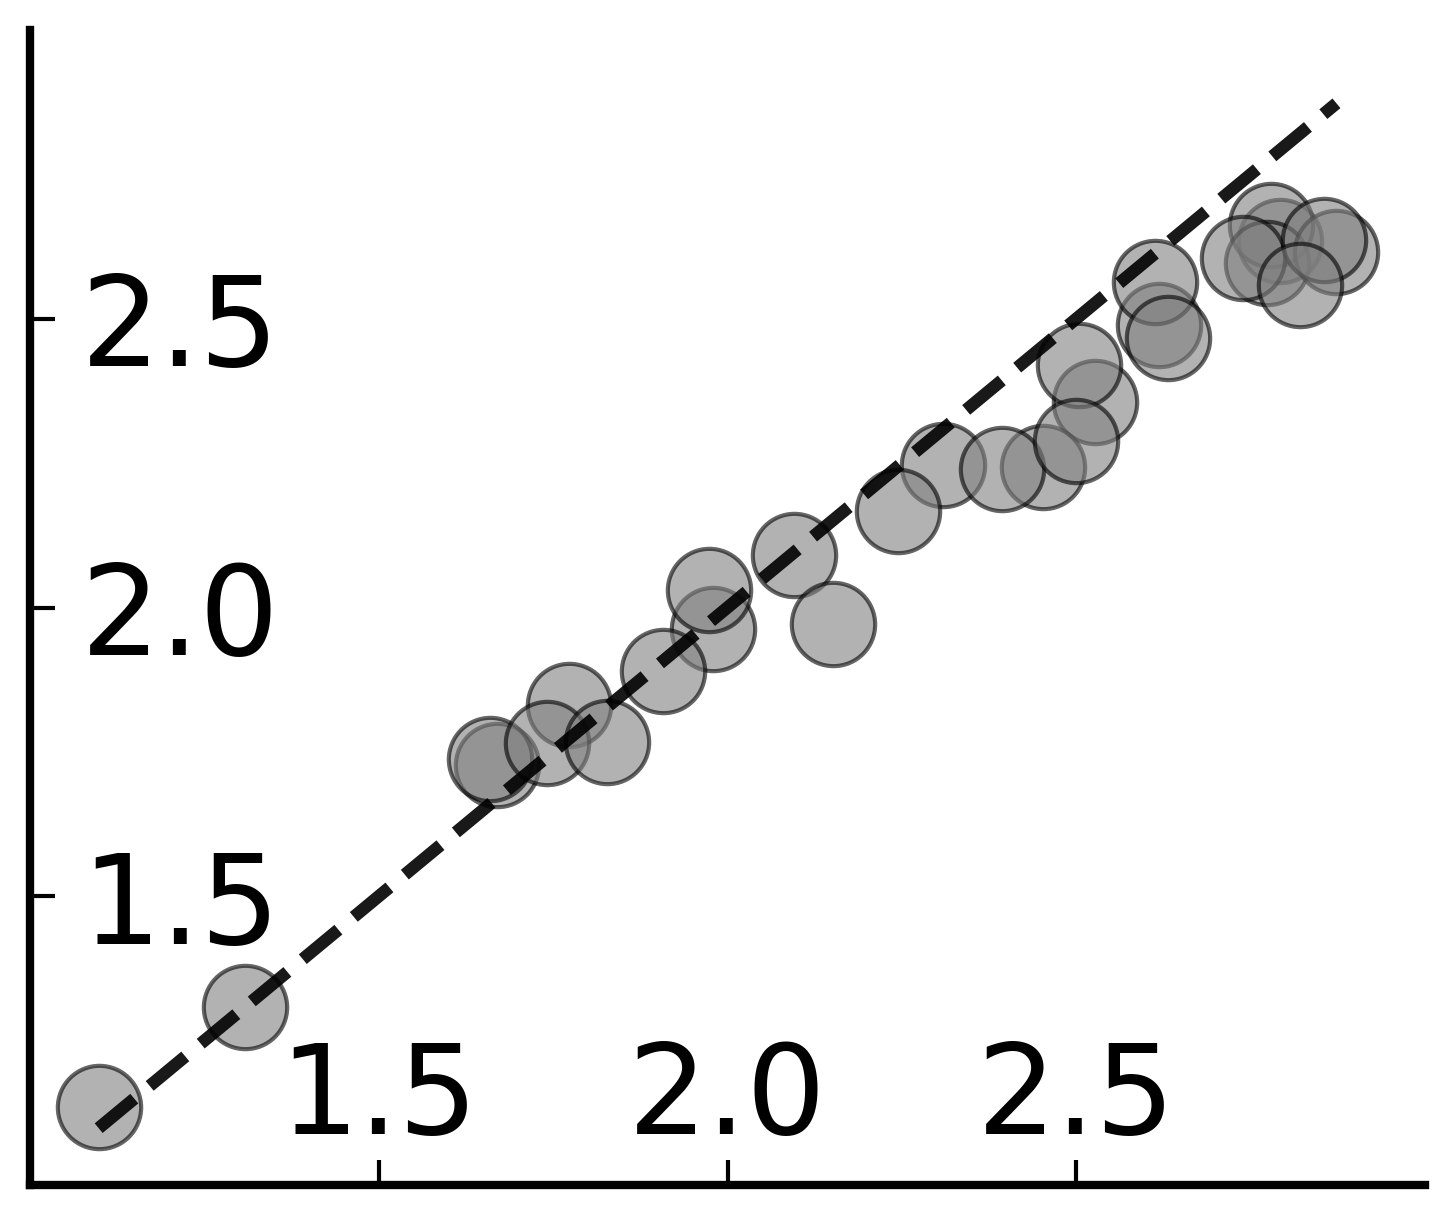

In [25]:
data1 = summer.groupby('Year')['AOU'].mean()
data2 = stratification + yearly_offsets + base_value

R2 = metrics.r2_score(data1, data2)

plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 5), dpi=300)
plt.style.use('default')

plt.scatter(data1, data2, alpha=0.6, color='grey', edgecolor='black', s=400)
print(R2)
sns.lineplot(x=data1, y=data1, color='black', linestyle='--', lw=3, zorder=1, alpha=0.9)


plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::2]) 
ax.set_yticks(ax.get_yticks()[::2])  
ax.set_xticks(ax.get_xticks()[1:-1]) 
ax.set_yticks(ax.get_yticks()[1:-1])  


ax.tick_params(axis='x', which='major', width=1, direction='in', length=6, pad=-35, labelsize=30)
ax.tick_params(axis='y', which='major', width=1, direction='in', length=6, pad=-60, labelsize=30)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('plot_Plume.png', transparent=True)

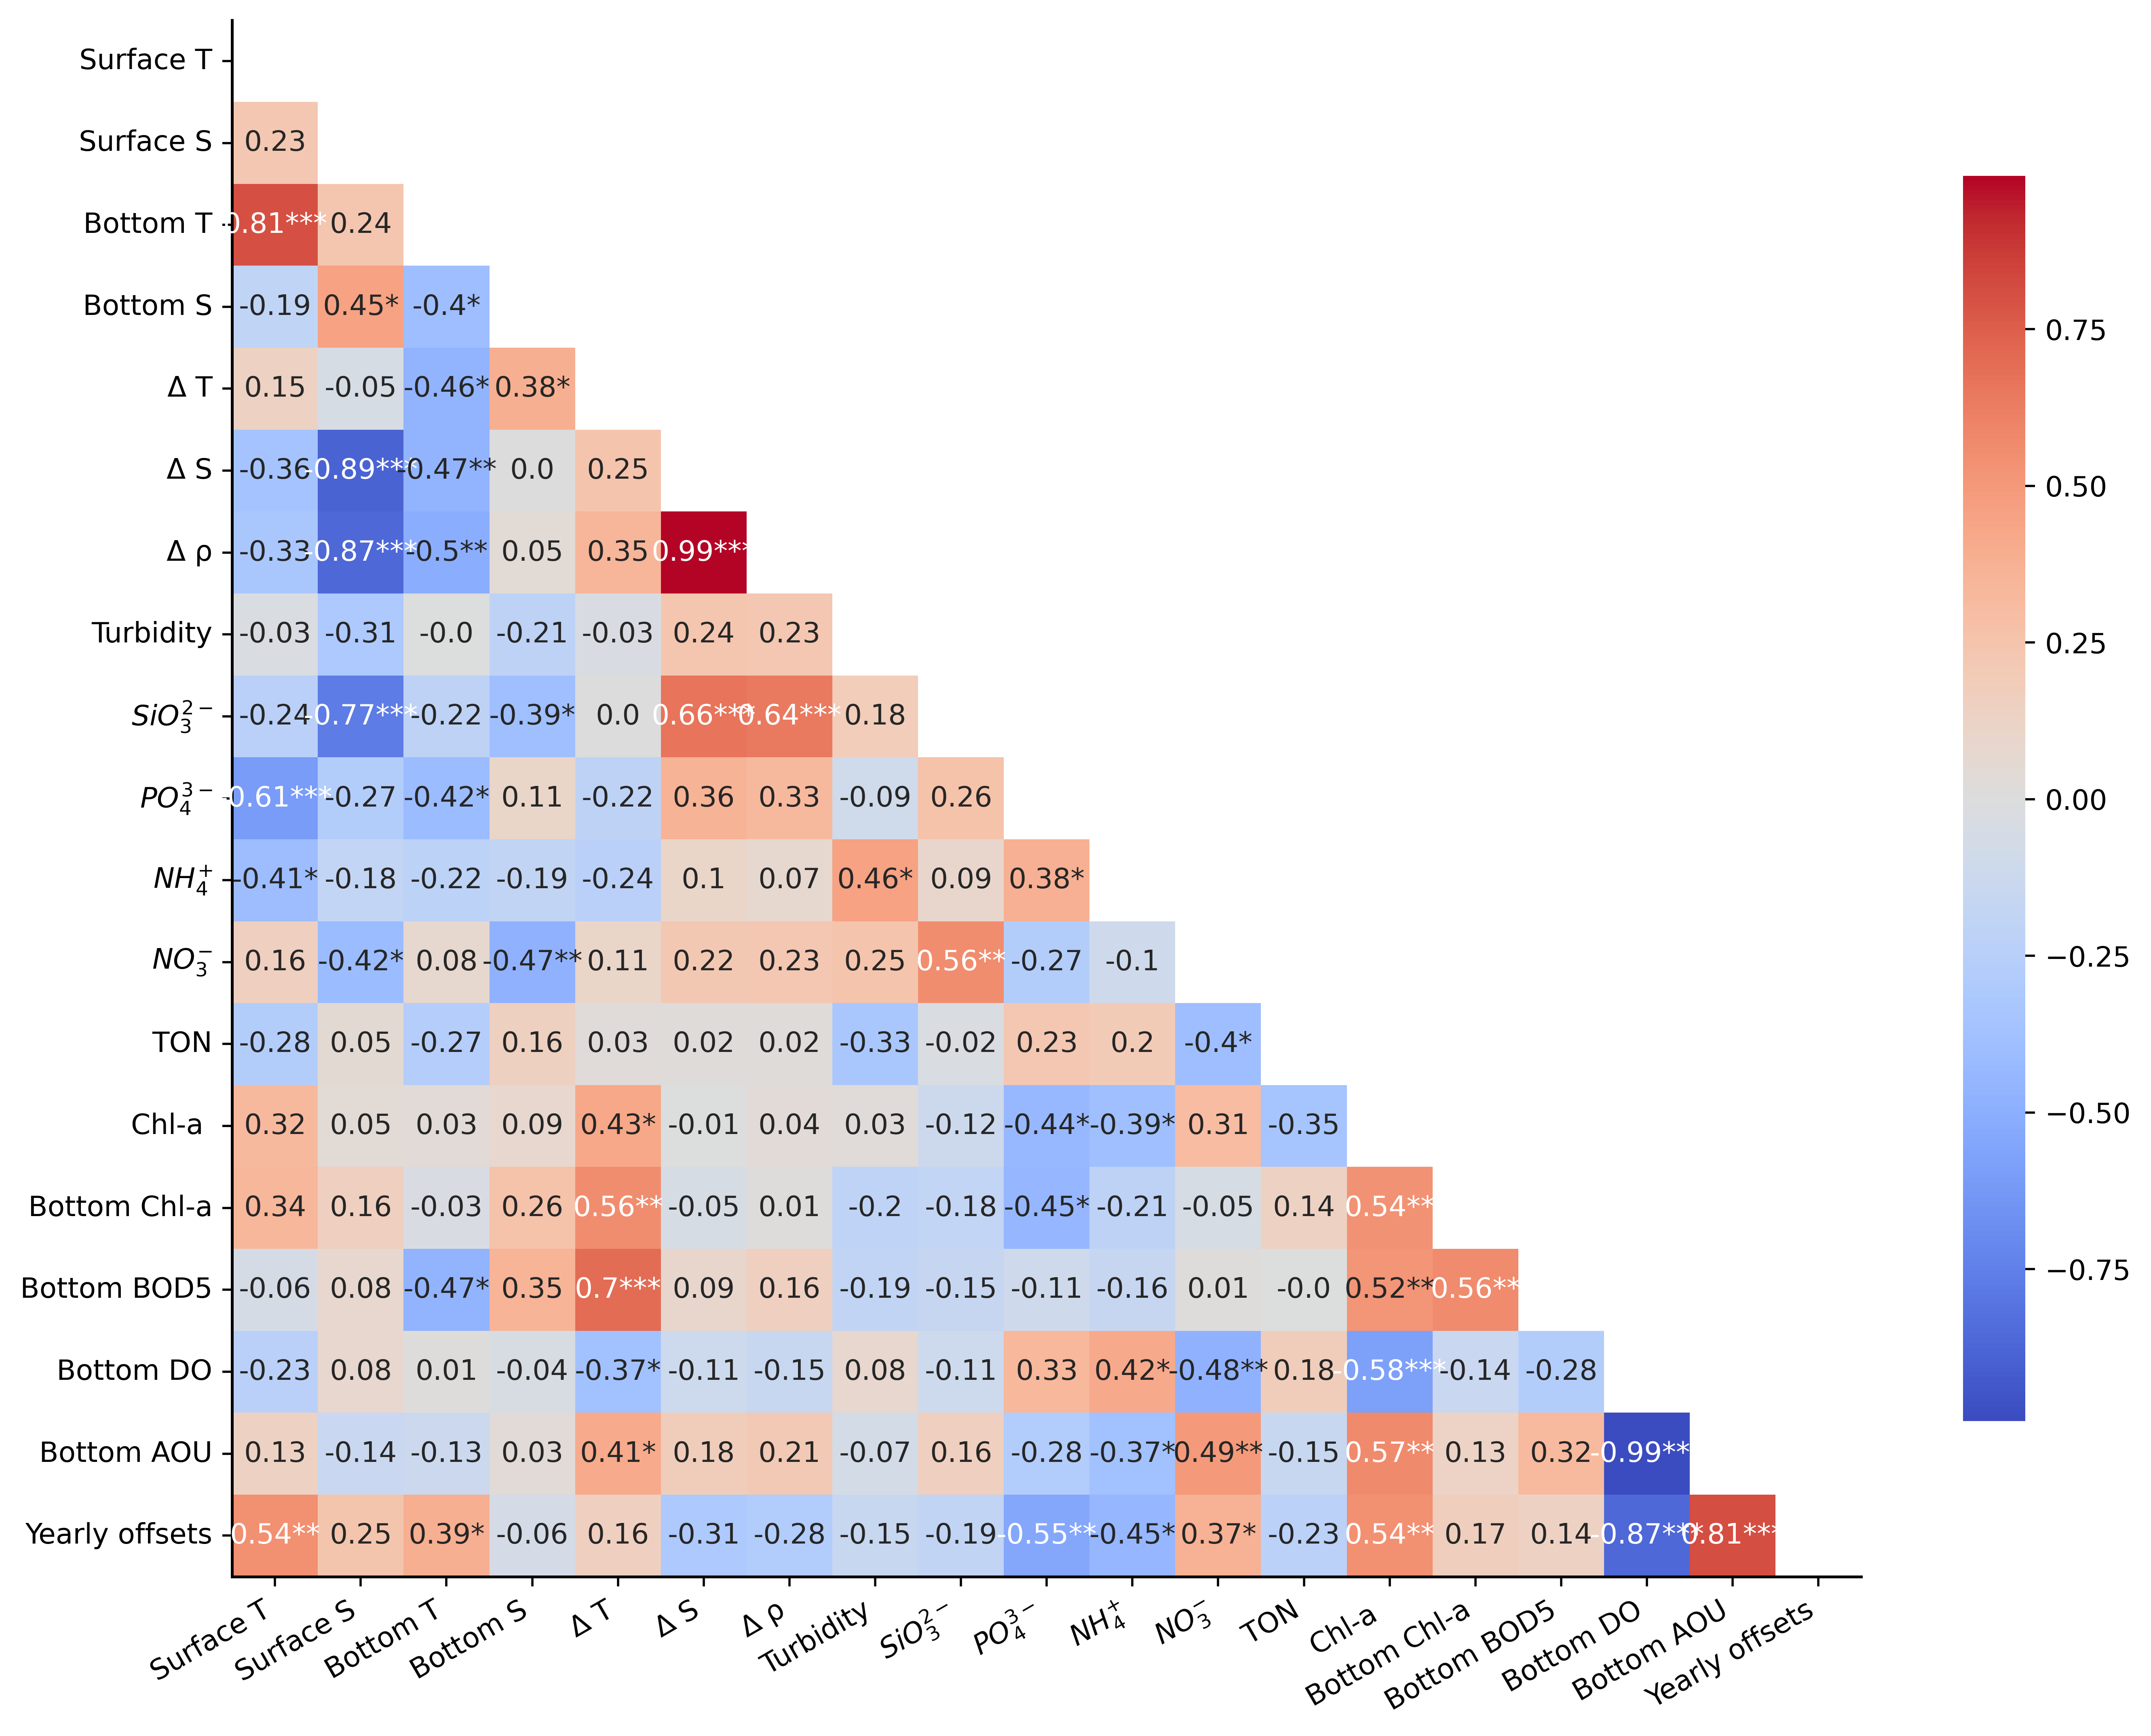

In [26]:
cor = summer.groupby('Year')[['Temperature (°C)surface', 'Salinity (psu)surface','Temperature (°C)bottom',
            'Salinity (psu)bottom','T_difference', 'S_difference', ] + ['density_difference','Turbidity (NTU)surface', 'Silica (mg/L)surface',
    'Orthophosphate Phosphorus (mmol/m3)surface', 'Ammonia Nitrogen (mmol/m3)surface','Nitrate Nitrogen (mmol/m3)surface',
    'Total Organic Nitrogen (mg/L)surface',
    'Chlorophyll-a (ug/L)surface','Chlorophyll-a (ug/L)bottom', '5-day Biochemical Oxygen Demand (mg/L)bottom',
    'Dissolved Oxygen (mg/L)bottom', 'AOU']].mean()

cor['Yearly offsets'] = yearly_offsets

corr_matrix = cor.corr()

p_values = pd.DataFrame(np.zeros((cor.shape[1], cor.shape[1])), columns=cor.columns, index=cor.columns)
for col in cor.columns:
    for row in cor.columns:
        _, p_value = stats.pearsonr(cor[col], cor[row])
        p_values.at[row, col] = p_value
        
def add_significance_stars(corr_matrix, p_values):
    sig = p_values.applymap(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
    return corr_matrix.round(2).astype(str) + sig

corr_with_significance = add_significance_stars(corr_matrix, p_values)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(13, 10),dpi=500)

ax = sns.heatmap(
    corr_matrix,
    mask=mask,                      
    cmap='coolwarm',                
    annot=corr_with_significance,   
    fmt="",                     

    cbar_kws={"shrink": 0.8},      
    
)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if i < j:  
            ax.add_patch(plt.Rectangle((j, i), 1, 1, edgecolor="none", facecolor="white", lw=0))

for spine in ['left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1)   
    ax.spines[spine].set_color('black') 
    
ax.set_xticklabels(['Surface T', 'Surface S', 'Bottom T', 'Bottom S','\u0394 T', '\u0394 S', '\u0394 \u03C1', 'Turbidity', '$SiO_3^{2-}$',
                   '$PO_4^{3-}$', '$NH_4^{+}$', '$NO_3^{-}$', 'TON',
                   'Chl-a ','Bottom Chl-a',  'Bottom BOD5',
                   'Bottom DO', 'Bottom AOU','Yearly offsets'],
                   rotation=30, horizontalalignment='right')
ax.set_yticklabels(['Surface T', 'Surface S', 'Bottom T', 'Bottom S','\u0394 T', '\u0394 S', '\u0394 \u03C1',  'Turbidity', '$SiO_3^{2-}$',
                   '$PO_4^{3-}$', '$NH_4^{+}$', '$NO_3^{-}$', 'TON',
                   'Chl-a ','Bottom Chl-a','Bottom BOD5',
                   'Bottom DO', 'Bottom AOU','Yearly offsets'])

None